# Problem Definition

Predict which pumps are functional, which need some repairs, and which don't work at all. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

# Importing Libraries

In [1]:
import os
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-5.3.0-posix-seh-rt_v4-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']


In [2]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import random
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import math
import xgboost as xgb
%matplotlib inline 

C:\Users\ysami\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
from xgboost import XGBClassifier

# Importing Datasets

In [4]:
train_value = pd.read_csv("Train_Set_Values.csv")
train_label = pd.read_csv("Train_Set_Labels.csv")
test = pd.read_csv("Test_Set_Values.csv")

### Check Target Categories' Distribution

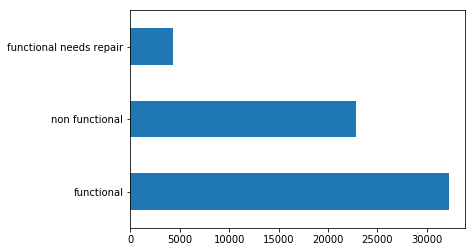

In [5]:
palette=[sns.color_palette()[0],sns.color_palette()[2],sns.color_palette()[1]]
train_label.status_group.value_counts().plot(kind='barh', color=palette)

# Data Preprations

## Combining Train Values and Labels

In [6]:
train_data = train_value.merge(train_label, how = "outer", on = "id", sort = True)

### Data Inspections

C:\Users\ysami\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


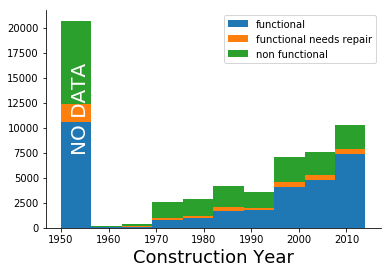

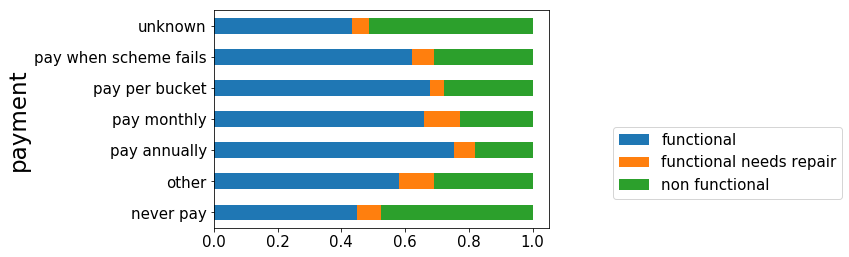

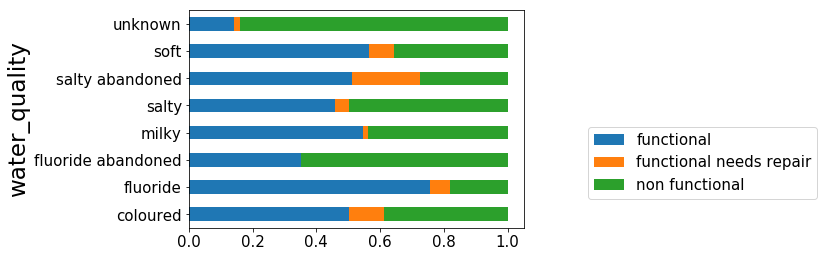

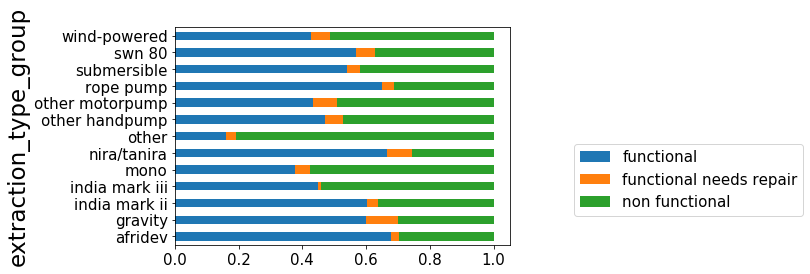

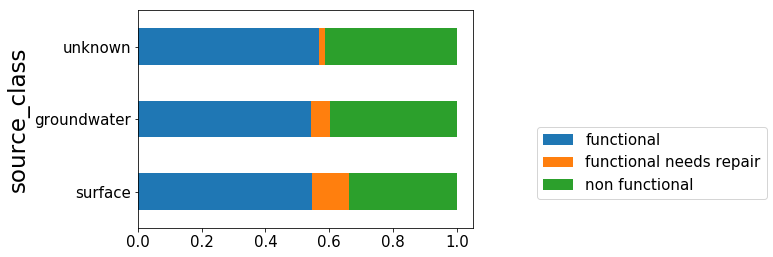

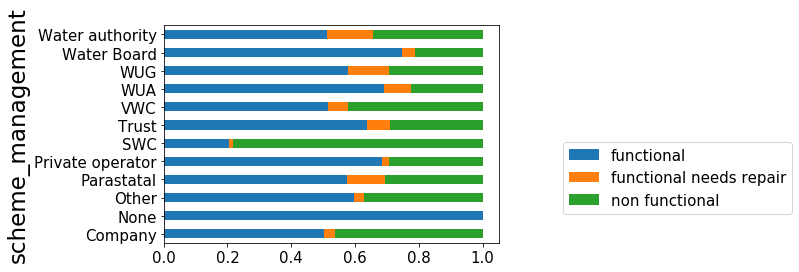

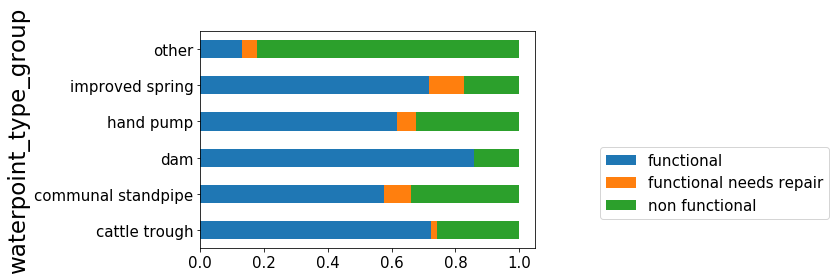

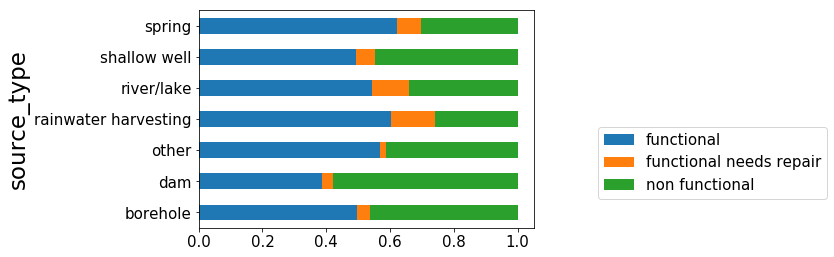

In [7]:
train_data.construction_year=pd.to_numeric(train_data.construction_year)
train_data.loc[train_data.construction_year <= 0, train_data.columns=='construction_year'] = 1950

hist1=train_data[train_data.status_group == 'functional'].construction_year
hist2=train_data[train_data.status_group == 'functional needs repair'].construction_year
hist3=train_data[train_data.status_group == 'non functional'].construction_year

n,b,p=plt.hist([hist1, hist2, hist3], stacked=True,range=[1950,2014])
plt.legend(['functional','functional needs repair','non functional'],loc=0)
plt.text(1952, 15000,'NO DATA',fontsize=20,rotation=90,color='white')
plt.xlabel('Construction Year', fontsize=18)

sns.despine()

factorstoplot=['payment','water_quality','extraction_type_group','source_class','scheme_management','waterpoint_type_group','source_type']
for i in range(1,len(factorstoplot)+1):
   
    thisFactor=factorstoplot[i-1]
    sumfactor=train_data.groupby([thisFactor]).status_group.count()
    temp=pd.DataFrame(train_data.groupby([thisFactor]).status_group.value_counts()/sumfactor)
    temp['status']=temp.index.get_level_values('status_group')
    temp['source']=temp.index.get_level_values(thisFactor)
    temp.columns=['n','status',thisFactor]
    temp=temp.pivot(index=thisFactor, columns='status', values='n')
    temp['tot']=temp.sum(axis=1)
    temp.sort_values(by='tot', ascending=True)[['functional','functional needs repair','non functional']].plot(kind='barh', stacked='True', color=sns.color_palette(), fontsize=15,legend=False)
    plt.legend( loc='upper right', bbox_to_anchor=(1.9, 0.5),fontsize=15)
    plt.ylabel(thisFactor, fontsize=23)

### Visual Analysis of the Data

Year of construction: 
*From this plot we can determine that there is a lot of null data. The rows with no data were assigned
the year of construction 1950.
*The year of construction and the last recording of the data has a relationship with how many wells are functional or not.

Main takeaway from categorical plots:
*These charts were plotted to understand the distribution of functional/non functional over the different levels.
Our main take away was that the less information available (for example groups "other" or "unknown"), the more non functional
wells were present.

Convert Recorded date into date type and check max

In [8]:
train_data['date_recorded']=train_data.date_recorded.apply(pd.to_datetime)

In [9]:
#To understand when the last reported date was. This is required for calculating operating time from the last recorded
# until today. 
train_data['date_recorded'].max()

Timestamp('2013-12-03 00:00:00')

## Combining Train and Test Values for Feauture Engineering Processes

In [10]:
combined_df=train_value.append(test)

In [11]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74250 entries, 0 to 14849
Data columns (total 40 columns):
id                       74250 non-null int64
amount_tsh               74250 non-null float64
date_recorded            74250 non-null object
funder                   69746 non-null object
gps_height               74250 non-null int64
installer                69718 non-null object
longitude                74250 non-null float64
latitude                 74250 non-null float64
wpt_name                 74250 non-null object
num_private              74250 non-null int64
basin                    74250 non-null object
subvillage               73780 non-null object
region                   74250 non-null object
region_code              74250 non-null int64
district_code            74250 non-null int64
lga                      74250 non-null object
ward                     74250 non-null object
population               74250 non-null int64
public_meeting           70095 non-null object
r

# Data Cleaning

## Null Imputation

All missing values of latitude, longitude and height (listed as 0s) are converted to the mean value within their administrative region For categorical variables, values that are rare (less than 20 occurences) are converted into "Others" Categorical variables are converted into numbers A new variable is introduced: timeago (how long ago the pump was checked).
In addition considering amount_tsh has too many values equal to 0 we have decided the best strategy is not to use this 
feature for modeling. 

In [12]:
#This is were we assigned the construction date 1950 for all missing values because we do not know the actual year. 
combined_df.construction_year=pd.to_numeric(combined_df.construction_year)
combined_df.loc[combined_df.construction_year <= 0, combined_df.columns=='construction_year'] = 1950

In [13]:
#Assuming rows with longitude or latitude less than 1 are null values. Using pandas it is easier to do the imputation
#for NaN than for 0. 
a= combined_df[combined_df["longitude"] < 1]
a.iloc[:,combined_df.columns == "latitude"]= np.nan
a.iloc[:,combined_df.columns == "longitude"]= np.nan
combined_df[combined_df["longitude"] < 1] = a

#The actual imputation was done by the mean of the region_code. We considered using subvillage instead for added detail, 
#however the process was complicated because it involved imputing null values for subvillage, and the improvement was 
#close to 0, and deemed not worth it. 
combined_df["longitude"] = combined_df.groupby("region_code").transform(lambda x: x.fillna(x.mean())).longitude
combined_df["latitude"] = combined_df.groupby("region_code").transform(lambda x: x.fillna(x.mean())).latitude



C:\Users\ysami\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [14]:
#Assuming rows with gps_height less than 1 are null values. Using pandas it is easier to do the imputation
#for NaN than for 0.
a= combined_df[combined_df["gps_height"] < 1]
a.iloc[:,combined_df.columns == "gps_height"]= np.nan
combined_df[combined_df["gps_height"] < 1] = a
combined_df["gps_height"] = combined_df.groupby("region_code").transform(lambda x: x.fillna(x.mean())).gps_height

C:\Users\ysami\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [15]:
#For the actual NaN imputation there were still some missing values so we took the mean. 
combined_df=combined_df.fillna(combined_df.mean())

# New Features

### Distance between wells 

In [16]:

#Calcluate a new feature that measures the distance between wells. We assume that in areas were there are a lot of wells
#near to each other, it is more likely that you will have non functional ones because they are redundant. So there is no
#incentive to repair them to keep them functional. 
distances = combined_df[['id','longitude','latitude']]
distances =distances.sort_values(by=['longitude','latitude'])
distances['coords']=distances[['longitude','latitude']].values.tolist()

In [17]:
# shifting the dataframe by one to compare distances between the wells. 
shift_distances=distances.shift(1).loc[:,'coords' ]
distances_2 = pd.concat([distances, shift_distances], axis=1)
distances_2.columns =['id','longitude','latitude','coord_1','coords_2']
distances_2['long2']=pd.to_numeric(distances_2['coords_2'].str[0])
distances_2['lat2']=pd.to_numeric(distances_2['coords_2'].str[1])
distances_2=distances_2.fillna(0)

In [18]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [19]:
#Creating the distance columns
distances_2['dist'] = distances_2.apply(lambda x: haversine_np(x[1], x[2], x[5], x[6]), axis = 1)
location=distances_2[['id','dist']]
combined_df=combined_df.merge(location, left_on='id', right_on='id', how='inner')

In [20]:
#We use the Current_date as the starting point to create three new features: operation_time, month, and age.
#The goal is to take into consideration the age of the well and how it has an impact on whether it is functional or not. 
combined_df['Current_Date']='2014-01-01'

#Operation_time, measures the period of the last recorded status and the current date. 
combined_df['operation_time']=combined_df.Current_Date.apply(pd.to_datetime)-combined_df.date_recorded.apply(pd.to_datetime)
combined_df['operation_time']= combined_df.operation_time.astype('timedelta64[D]').astype(int)
#Month of the last recorded status
combined_df['month']=pd.to_datetime(combined_df.date_recorded).dt.month

#The age of the construction of the well based on the difference with the current date. 
combined_df['age']=combined_df.Current_Date.apply(pd.to_datetime)-combined_df.construction_year.apply(lambda x: pd.to_datetime(x,format='%Y'))
combined_df['age']= combined_df.age.astype('timedelta64[Y]').astype(int)

## Factors Creation

In [21]:
#For values that have low frequency we are bundling them together as other. 
factorschange=[x for x in combined_df.columns if x not in ['id','latitude','longitude','gps_height','date_recorded','construction_year','month','operation_time','dist']]

for factor in factorschange:


    values_factor=combined_df[factor].value_counts()
    lessthen=values_factor[values_factor < 20]
    listnow=combined_df.installer.isin(list(lessthen.keys()))
    combined_df.loc[listnow,factor] = 'Others'

    # names to numbers
    combined_df[factor] = preprocessing.LabelEncoder().fit_transform(combined_df[factor].astype(str))

## Normalization (Logging skewed vars)

In [22]:
combined_df.population = combined_df.population.apply(lambda x: np.log10(x+1))

# Cross-Validation: Data Sepertaion

In [23]:
training_set=combined_df[:len(train_value)] 

In [24]:
test_set=combined_df[len(train_value):]

## Feature Selection

For feature selection we removed features that had too many NA's such as amount_tsh. Then for new features we did 
a trial an error approach. We would add the new feature to the set used for modeling and we would evaluate the result

In [25]:
# use these variables - room for improvement here


factors=[u'funder', u'gps_height',
       u'installer', u'longitude', u'latitude', u'wpt_name',
       u'basin', u'subvillage', u'region', u'region_code', u'district_code',
       u'lga', u'ward', u'population', u'public_meeting',
       u'scheme_management', u'scheme_name', u'permit', u'construction_year',
       u'extraction_type', u'extraction_type_group', u'extraction_type_class',
       u'management', u'management_group', u'payment', u'payment_type',
       u'water_quality', u'quality_group', u'quantity', u'quantity_group',
       u'source', u'source_type', u'source_class', u'waterpoint_type',
       u'waterpoint_type_group','month','operation_time','age']


# factors = ["funder","installer","management",
#                "region","lga","population",
#                "latitude","longitude","gps_height",
#                "scheme_management",
#                "public_meeting","permit",
#                "water_quality","quantity",
#                "payment_type","source","source_class",
#                "management","management_group",
#                "basin","extraction_type","waterpoint_type",
#                "timeago"]

X_train, X_test, y_train, y_test = train_test_split(training_set[factors], train_label.status_group, test_size=0.1, random_state=10)


print (len(X_train), len(X_test))

53460 5940


training_set = training_set.merge(train_label, how = "inner", on = "id", sort = True)

# Models Intitiation

## Train and Score Models

53460 5940
Random Forest 0.8069023569023569
Decision Tree 0.6755892255892256
Extra Trees Classifiers 0.8095959595959596
XGboost Classifiers 0.7496632996632997


C:\Users\ysami\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Text(0,0.5,'Score')

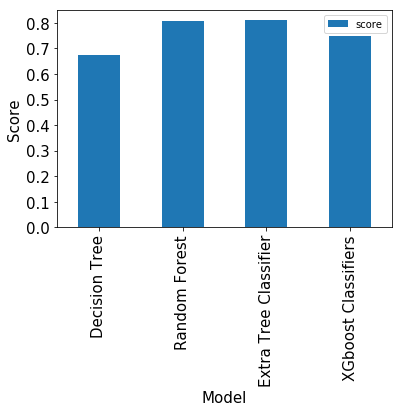

In [26]:

print (len(X_train), len(X_test))
modelRFC = RandomForestClassifier(n_estimators=1000,min_samples_split=5,bootstrap=True)


X_test=(X_test - X_test.min())/(X_test.max() - X_test.min())
X_train=(X_train - X_train.min())/(X_train.max() - X_train.min())

modelRFC.fit(X_train, y_train)

modelETC = ExtraTreesClassifier(n_estimators=1000,min_samples_split=10)
modelETC.fit(X_train, y_train)


modelXclass = XGBClassifier()  # and for classifier  
modelXclass.fit(X_train, y_train)  
 

modelDTC = DecisionTreeClassifier()
modelDTC.fit(X_train, y_train)

scoreRFC= modelRFC.score(X_test,y_test)
scoreDTC= modelDTC.score(X_test,y_test)
scoreETC= modelETC.score(X_test,y_test)

scoreXclass= modelXclass.score(X_test,y_test)

print ('Random Forest' ,scoreRFC)
print ('Decision Tree', scoreDTC)
print ('Extra Trees Classifiers', scoreETC)
print ('XGboost Classifiers', scoreXclass)

pd.DataFrame([
    ("Decision Tree", scoreDTC),
    ("Random Forest", scoreRFC),
    ("Extra Tree Classifier", scoreETC),
    ("XGboost Classifiers", scoreXclass),
    ], columns=["Model", "score"]).plot(x="Model", y="score", kind="Bar", fontsize=15)
plt.xlabel('Model', fontsize=15)
plt.ylabel('Score', fontsize=15)

Based on the chart aboved we selected our best performing models to carry out in depth cross validation. 

# Cross Validation

## Confusion Matrix

Confusion matrix, without normalization
[[2968   47  253]
 [ 240  117   55]
 [ 507   29 1724]]
Normalized confusion matrix
[[0.91 0.01 0.08]
 [0.58 0.28 0.13]
 [0.22 0.01 0.76]]


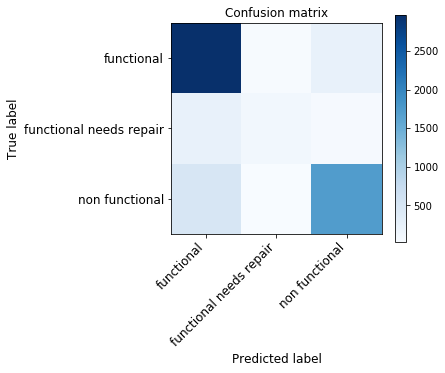

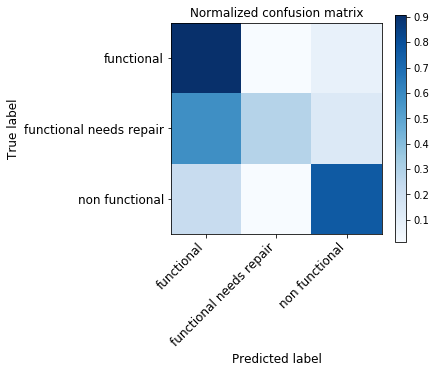

Test Score 0.8095959595959596


In [27]:
plt.rcParams['figure.figsize'] = (6.0, 6.0)

from sklearn.metrics import confusion_matrix
labels=['functional','functional needs repair','non functional']
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(shrink=0.7)
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45, ha='right', fontsize=12)
    plt.yticks(tick_marks, labels , fontsize=12)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)


# Compute confusion matrix
cm = confusion_matrix(y_test, modelETC.predict(X_test))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()
print ('Test Score', cm.diagonal().sum()/float(cm.sum()))

Confusion matrix, without normalization
[[2943   58  267]
 [ 237  116   59]
 [ 497   29 1734]]
Normalized confusion matrix
[[0.9  0.02 0.08]
 [0.58 0.28 0.14]
 [0.22 0.01 0.77]]


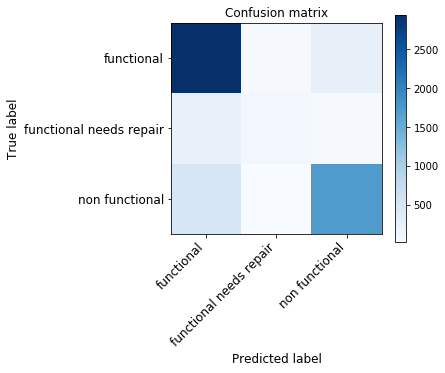

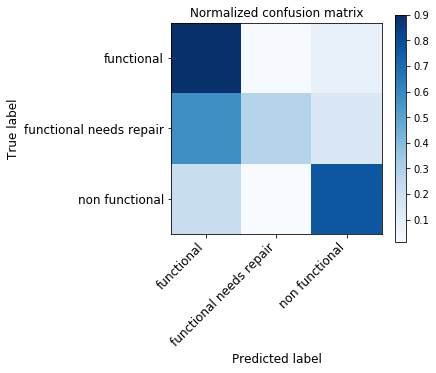

Test Score 0.8069023569023569


In [28]:
plt.rcParams['figure.figsize'] = (6.0, 6.0)

from sklearn.metrics import confusion_matrix
labels=['functional','functional needs repair','non functional']
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(shrink=0.7)
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45, ha='right', fontsize=12)
    plt.yticks(tick_marks, labels , fontsize=12)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)


# Compute confusion matrix
cm = confusion_matrix(y_test, modelRFC.predict(X_test))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()
print ('Test Score', cm.diagonal().sum()/float(cm.sum()))

### Evaluation of confusion matrices 

In general the two models have the same precision. However we have chosen model_ETC, because it is better at predicting the pumps that are functional and don't need repair, and at predicting the pumps that are actually non functional. In other words the situation we are trying to avoid a situation in which someone decides to spend time and money fixing a pump, only to find out it is actually working. 


# Re-join train and validation datasets

# Prediction Result

We run the model on the whole training set and the we predict on it.

In [30]:
model=modelETC

X_train=training_set[factors]
y_train =train_label.status_group
X_train=(X_train - X_train.min())/(X_train.max() - X_train.min())

model.fit(X_train, y_train)



X_topredict=test_set[factors]
X_topredict=(X_topredict - X_topredict.min())/(X_topredict.max() - X_topredict.min())
predict=model.predict(X_topredict)


test_set['status_group']=predict

test_set[['id','status_group']].to_csv('outputETC.csv',index=False)

## Hyper parameter tunning

For the two best performing models, we ran a loop that determines the ideal maximum number of features and maximum split to minimize error. This way we were able to make the process of trial and error faster and more efficient. 